<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

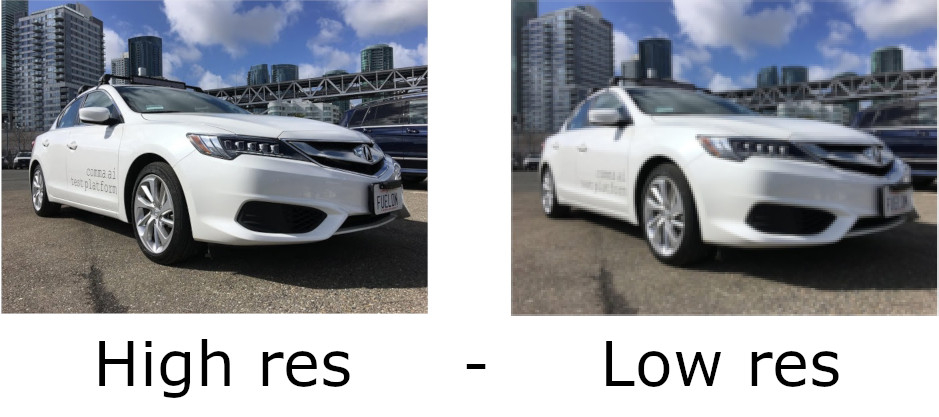

## Import Libraries

In [ ]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/data.zip"
!unzip -qo data.zip 
!rm data.zip

--2021-12-16 01:15:56--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.63
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116362032 (111M) [application/zip]
Saving to: ‘data.zip’

data.zip              0%[                    ]  40.56K  80.9KB/s               

## What are Autoencoders?

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

## Build the Encoder

In [ ]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [ ]:
encoder.summary()

## Build the Decoder to Complete the Network

In [ ]:
input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)

In [ ]:
# Decoder
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='nadam', loss='logcosh')

## Create Dataset and Specify Training Routine

In [ ]:
def train_batches(just_load_dataset=False):

    # Number of images to have at the same time in a batch
    batches = 256 
    
    # Number if images in the current batch (grows over time and then resets for each batch)
    batch = 0 
    
    # For printing purpose
    batch_nb = 0
    
    max_batches = -1
    
    # Number of epochs
    ep = 4 

    images = []
    x_train_high = []
    x_train_low = []
    
    x_train_high2 = [] # Resulting high res dataset
    x_train_low2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("data"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    
                    # Resize the image so that every image is the same size
                    image_resized = resize(image, (256, 256)) 
                    x_train_high.append(image_resized) # Add this image to the high res dataset
                    x_train_low.append(rescale(rescale(image_resized, 0.5, multichannel=True), 2.0, multichannel=True)) # Creating the blurred images
                    batch += 1
                    if batch == batches:
                        
                        x_train_high2 = np.array(x_train_high)
                        x_train_low2 = np.array(x_train_low)
                        
                        if just_load_dataset:
                            return x_train_high2, x_train_low2
                        
                        batch_nb += 1
                        print('Training batch', batch_nb)

                        autoencoder.fit(x_train_low2, x_train_high2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_high = []
                        x_train_low = []
                    
                        batch = 0

    return x_train_high2, x_train_low2

## Load the Dataset and Pre-trained Model

In [ ]:
x_train_n, x_train_down = train_batches(just_load_dataset=False)

In [ ]:
autoencoder.load_weights("/content/drive/MyDrive/Image_SuperResolution---Belajar_Coding/data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5")

## Model Predictions and Visualizing the Results

In [ ]:
encoder.load_weights('/content/drive/MyDrive/Image_SuperResolution---Belajar_Coding/data/encoder_weights.hdf5')

In [ ]:
encoded_imgs = encoder.predict(x_train_down)

In [ ]:
encoded_imgs.shape

In [ ]:
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [ ]:
image_index = 25

In [ ]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()